In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error

In [56]:
data = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv')
data.columns

Index(['ntsb_no', 'ev_type', 'ev_time', 'ev_country', 'ev_year', 'ev_month',
       'latitude', 'longitude', 'apt_dist', 'gust_kts', 'altimeter',
       'ev_highest_injury', 'ev_inj_tot_f', 'ev_inj_tot_m', 'ev_inj_tot_n',
       'ev_inj_tot_s', 'ev_inj_tot_t', 'aircraft_count', 'Aircraft_ID',
       'event_key', 'damage', 'num_eng', 'acft_fatal_count',
       'acft_minor_count', 'acft_none_count', 'acft_serious_count',
       'acft_total_person_count', 'acft_injured_person_count', 'insp_date',
       'event_date', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUB

In [57]:
# Define the problem / available data
target = 'acft_prop_inj_s'
data = data[(~data['latitude'].isna()) & (~data[target].isna())]

In [58]:
def reformat_latitude_longitude(str):
    '''
    Takes string xxxxxxY where:
        x are digits (implied decimal after second digit)
        Y is N/S/E/W 
    Returns latitude/longitude in radians
    '''
    num_as_float = float(str[0:2]+'.'+str[2:-1])
    rads = radians(num_as_float)

    if str[-1] == 'S' or str[-1] == 'W':
        return -rads
    else:
        return rads

In [59]:
#Reformat latitude + longitude to radians; needed for Haversine metric
data['longitude'] = data['longitude'].apply(reformat_latitude_longitude)
data['latitude'] = data['latitude'].apply(reformat_latitude_longitude)

In [60]:
# Train / test split
data_train, data_val = train_test_split(data, test_size=0.2)

# Baseline model: predict average
avg = data_train[target].mean()
baseline_preds = np.ones(len(data_train)) * avg

# Baseline model: probabilities version
# baseline_preds = np.zeros(shape=(len(data),4))
# baseline_preds[:,2] = np.ones(shape=(len(data)))

In [ ]:
# Shuffle the data
# Note that GridSearchCV does not shuffle the data before doing StratifiedKFold split
data_shuffled = data_train.sample(frac=1)

X_tr = data_shuffled[['latitude','longitude']]
y_tr = data_shuffled[target]

params = {'n_neighbors': [1,2,5,10,20,50,100,200,300,400,500]}

grid_search = GridSearchCV(
    KNeighborsRegressor(metric='haversine'),
    params,
    scoring='neg_mean_squared_error',
    cv=10
)

grid_search.fit(X_tr,y_tr)

,estimator,KNeighborsReg...c='haversine')
,param_grid,"{'n_neighbors': [1, 2, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,500


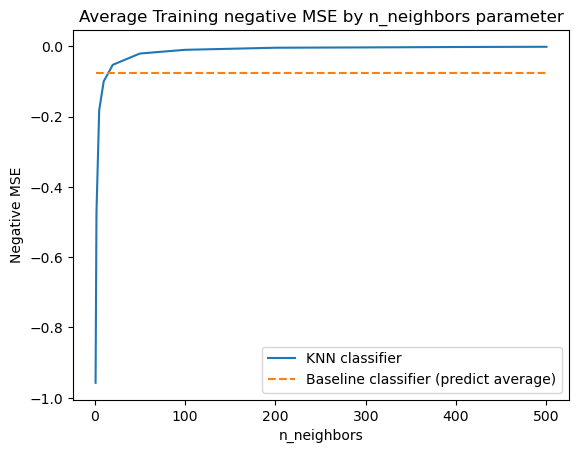

In [62]:
# Get macro-average F1 scores for baseline model and KNN for each parameter value
baseline_score = -mean_squared_error(y_tr, baseline_preds)
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot macro-average F1 scores
plt.plot(results_df['param_n_neighbors'], results_df['mean_test_score'], label='KNN classifier')
plt.plot(results_df['param_n_neighbors'], baseline_score * np.ones(len(results_df)), 
         label='Baseline classifier (predict average)', linestyle='--')

# Label the graph
plt.xlabel('n_neighbors')
plt.ylabel('Negative MSE')
plt.title('Average Training negative MSE by n_neighbors parameter')
plt.legend()

plt.show()

In [63]:
knn = grid_search.best_estimator_
knn.fit(X_tr, y_tr)

,n_neighbors,500
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'haversine'
,metric_params,None
,n_jobs,None


In [64]:
# Validation data
X_val = data_val[['latitude','longitude']]
y_val = data_val[target]

# Validation set performance
preds = knn.predict(X_val)
model_mse = mean_squared_error(y_val, preds)

# Validation set baseline predictions
baseline_preds = np.ones(len(data_val)) * avg
baseline_mse = mean_squared_error(y_val, baseline_preds)

print(f'Target variable: {target}')
print(f'Model MSE: {model_mse}')
print(f'Baseline MSE: {baseline_mse}')

Target variable: acft_prop_inj_s
Model MSE: 0.08168457581045831
Baseline MSE: 0.08146860133029118
